# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
using Base.Threads
println("Usando ", nthreads(), " threads 😎")

Usando 32 threads 😎


In [2]:
import Pkg

# Activa el entorno del proyecto
Pkg.activate("../")

# Pkg.rm("GLMakie")

# Resuelve y asegura dependencias
Pkg.resolve()
Pkg.instantiate()

# Evita errores de versiones incompatibles forzando actualización
# Pkg.update(["CairoMakie", "Revise", "CUDA", "Distributions"])

# Carga los paquetes de forma ordenada
using Revise
using CellBasedModels
using CUDA
using Distributions
using CairoMakie
using JSON

# Importa funciones específicas después
import CairoMakie: Point3f, Cylinder, Sphere, NoShading

CairoMakie.activate!()



  Activating project at `/data/samanthafs/homes/users/jvicens/ABM_CBM`


  No Changes to `/data/samanthafs/homes/users/jvicens/ABM_CBM/Project.toml`
  No Changes to `/data/samanthafs/homes/users/jvicens/ABM_CBM/Manifest.toml`


Precompiling 

project...


┌ Warning: attempting to remove probably stale pidfile
│   path = "/data/samanthafs/homes/users/jvicens/.julia/compiled/v1.10/CairoMakie/9mSey_GLM4i.ji.pidfile"
└ @ FileWatching.Pidfile /data/samanthafs/homes/users/jvicens/julia/julia-1.10.3/share/julia/stdlib/v1.10/FileWatching/src/pidfile.jl:244


  ✓ LinearSolve → LinearSolveFastAlmostBandedMatricesExt


┌ Warning: attempting to remove probably stale pidfile
│   path = "/data/samanthafs/homes/users/jvicens/.julia/compiled/v1.10/NonlinearSolveNLsolveExt/IOynl_GLM4i.ji.pidfile"
└ @ FileWatching.Pidfile /data/samanthafs/homes/users/jvicens/julia/julia-1.10.3/share/julia/stdlib/v1.10/FileWatching/src/pidfile.jl:244


  ✓ NonlinearSolve → NonlinearSolveNLsolveExt


  ✓ NonlinearSolve → NonlinearSolveBandedMatricesExt


  ✓ CairoMakie


  ✓ OrdinaryDiffEq


  ✓ DelayDiffEq


  ✓ StochasticDiffEq


  ✓ BoundaryValueDiffEq


  ✓ BoundaryValueDiffEq → BoundaryValueDiffEqOrdinaryDiffEqExt


  ✓ DifferentialEquations


  ✓ CellBasedModels
  11 dependencies successfully precompiled in 155 seconds. 410 already precompiled.


[ Info: Precompiling CellBasedModels [388cb286-f2b1-4654-a3bb-2e137a39c658]


Precompiling CairoMakie


  ✓ ColorVectorSpace → SpecialFunctionsExt


  ✓ SpecialFunctions → SpecialFunctionsChainRulesCoreExt


  ✓ IntervalArithmetic → IntervalArithmeticForwardDiffExt


  ✓ StatsFuns → StatsFunsChainRulesCoreExt


  ✓ Distributions → DistributionsChainRulesCoreExt


  ✓ KernelDensity


  ✓ Makie


  ✓ CairoMakie
  8 dependencies successfully precompiled in 116 seconds. 242 already precompiled.


[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]


┌ Warning: Module Distributions with build ID fafbfcfd-f901-01ff-001d-bb3b7ed99d54 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0].


Precompiling 

Makie


  ✓ libsixel_jll


  ✓ XSLT_jll


  ✓ Sixel


  ✓ PNGFiles


  ✓ Libglvnd_jll


  ✓ libwebp_jll


  ✓ Cairo_jll


  ✓ WebP


  ✓ HarfBuzz_jll


  ✓ libass_jll


  ✓ GridLayoutBase


  ✓ FFMPEG_jll


  ✓ Makie
  13 dependencies successfully precompiled in 96 seconds. 233 already precompiled.
[ Info: Precompiling Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a]


┌ Warning: Module Distributions with build ID fafbfcfd-f901-01ff-001d-bb3b7ed99d54 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a].


Precompiling SpecialFunctionsExt


  ✓ KernelAbstractions → EnzymeExt


  ✓ CUDA → ChainRulesCoreExt
  2 dependencies successfully precompiled in 56 seconds. 127 already precompiled.
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b]


┌ Warning: Module SpecialFunctions with build ID fafbfcfd-464b-e2ea-001d-bb3ba93c4a9b is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b].


Precompiling DiffEqBaseUnitfulExt


  ✓ DiffEqBase → DiffEqBaseUnitfulExt


  ✓ DiffEqBase → DiffEqBaseChainRulesCoreExt
  2 dependencies successfully precompiled in 6 seconds. 169 already precompiled.
[ Info: Precompiling DiffEqBaseUnitfulExt [aeb06bb4-539b-5a1b-8332-034ed9f8ca66]


┌ Warning: Module DiffEqBase with build ID fafbfcfd-e6a6-d243-001d-bb4112f7a03d is missing from the cache.
│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing DiffEqBaseUnitfulExt [aeb06bb4-539b-5a1b-8332-034ed9f8ca66].


[ Info: Precompiling KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b]


┌ Warning: Module Distributions with build ID fafbfcfd-f901-01ff-001d-bb3b7ed99d54 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing KernelDensity [5ab0869b-81aa-558d-bb23-cbf5423bbe9b].


[ Info: Precompiling ChainRulesCoreExt [eae2faf6-b232-58cb-a410-7764fda2830c]


┌ Warning: Module CUDA with build ID fafbfcfd-7396-1a92-001d-bb2e8a70b3fa is missing from the cache.
│ This may mean CUDA [052768ef-5323-5732-b1bb-66c8b64840ba] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing ChainRulesCoreExt [eae2faf6-b232-58cb-a410-7764fda2830c].


[ Info: Precompiling SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188]


┌ Warning: Module SpecialFunctions with build ID fafbfcfd-464b-e2ea-001d-bb3ba93c4a9b is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188].


[ Info: Precompiling StatsFunsChainRulesCoreExt [d41313fe-2684-5453-9fef-703f5fa397f4]


┌ Warning: Module StatsFuns with build ID fafbfcfd-1cde-a65f-001d-bb3b991874ef is missing from the cache.
│ This may mean StatsFuns [4c63d2b9-4356-54db-8cca-17b64c39e42c] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing StatsFunsChainRulesCoreExt [d41313fe-2684-5453-9fef-703f5fa397f4].


[ Info: Precompiling DistributionsChainRulesCoreExt [6db1f127-056a-568b-bd49-ae61d42389fa]


┌ Warning: Module Distributions with build ID fafbfcfd-f901-01ff-001d-bb3b7ed99d54 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing DistributionsChainRulesCoreExt [6db1f127-056a-568b-bd49-ae61d42389fa].


[ Info: Precompiling DiffEqBaseChainRulesCoreExt [b00db79b-61e3-50fb-b26f-2d35b2d9e4ed]


┌ Warning: Module DiffEqBase with build ID fafbfcfd-e6a6-d243-001d-bb4112f7a03d is missing from the cache.
│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing DiffEqBaseChainRulesCoreExt [b00db79b-61e3-50fb-b26f-2d35b2d9e4ed].


Precompiling ForwardDiffExt


  ✓ LoopVectorization → ForwardDiffExt
  1 dependency successfully precompiled in 2 seconds. 132 already precompiled.
[ Info: Precompiling ForwardDiffExt [4b8ca102-9d0f-5df8-84ed-253e0f005ba7]


┌ Warning: Module ForwardDiff with build ID fafbfcfd-8d1b-89e0-001d-bb41382cb478 is missing from the cache.
│ This may mean ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing ForwardDiffExt [4b8ca102-9d0f-5df8-84ed-253e0f005ba7].


Precompiling SimpleNonlinearSolveChainRulesCoreExt


  ✓ SimpleNonlinearSolve → SimpleNonlinearSolveChainRulesCoreExt
  1 dependency successfully precompiled in 19 seconds. 196 already precompiled.
[ Info: Precompiling SimpleNonlinearSolveChainRulesCoreExt [073a8d7d-86ee-5d75-9348-f9bf6155b014]


┌ Warning: Module DiffEqBase with build ID fafbfcfd-e6a6-d243-001d-bb4112f7a03d is missing from the cache.
│ This may mean DiffEqBase [2b5f629d-d688-5b77-993f-72d75c75574e] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing SimpleNonlinearSolveChainRulesCoreExt [073a8d7d-86ee-5d75-9348-f9bf6155b014].


[ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]


Precompiling GridLayoutBase


  ✓ GridLayoutBase
  1 dependency successfully precompiled in 10 seconds. 22 already precompiled.
[ Info: Precompiling GridLayoutBase [3955a311-db13-416c-9275-1d80ed98e5e9]


┌ Warning: Module GeometryBasics with build ID fafbfcfd-a2e9-6fb9-001d-bbc815bf422d is missing from the cache.
│ This may mean GeometryBasics [5c1252a2-5f33-56bf-86c9-59e7332b4326] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948


[ Info: Skipping precompilation since __precompile__(false). Importing GridLayoutBase [3955a311-db13-416c-9275-1d80ed98e5e9].


[ Info: Precompiling DelaunayTriangulation [927a84f5-c5f4-47a5-9785-b46e178433df]


Precompiling IntervalArithmeticForwardDiffExt


  ✓ IntervalArithmetic → IntervalArithmeticForwardDiffExt
  1 dependency successfully precompiled in 3 seconds. 28 already precompiled.
[ Info: Precompiling IntervalArithmeticForwardDiffExt [ba47a815-ec9a-57c1-b718-e4e972ac9261]


┌ Warning: Module IntervalArithmetic with build ID fafbfcfd-4743-ad62-001d-bbebac2dfe73 is missing from the cache.
│ This may mean IntervalArithmetic [d1acc4aa-44c8-5952-acd4-ba5d80a2a253] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing IntervalArithmeticForwardDiffExt [ba47a815-ec9a-57c1-b718-e4e972ac9261].


Precompiling IntervalArithmeticRecipesBaseExt


  ✓ IntervalArithmetic → IntervalArithmeticRecipesBaseExt
  1 dependency successfully precompiled in 0 seconds. 32 already precompiled.
[ Info: Precompiling IntervalArithmeticRecipesBaseExt [e3b91bd4-2888-5303-85ed-4cf5ebb38ff1]


┌ Warning: Module IntervalArithmetic with build ID fafbfcfd-4743-ad62-001d-bbebac2dfe73 is missing from the cache.
│ This may mean IntervalArithmetic [d1acc4aa-44c8-5952-acd4-ba5d80a2a253] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing IntervalArithmeticRecipesBaseExt [e3b91bd4-2888-5303-85ed-4cf5ebb38ff1].


[ Info: Precompiling IntervalArithmeticDiffRulesExt [86439bda-9ede-5c22-99a0-f82df582fb22]


┌ Warning: Module IntervalArithmetic with build ID fafbfcfd-4743-ad62-001d-bbebac2dfe73 is missing from the cache.
│ This may mean IntervalArithmetic [d1acc4aa-44c8-5952-acd4-ba5d80a2a253] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing IntervalArithmeticDiffRulesExt [86439bda-9ede-5c22-99a0-f82df582fb22].


Precompiling IntervalArithmeticIntervalSetsExt


  ✓ IntervalArithmetic → IntervalArithmeticIntervalSetsExt
  1 dependency successfully precompiled in 0 seconds. 35 already precompiled.
[ Info: Precompiling IntervalArithmeticIntervalSetsExt [fe1c01f3-e48c-5d10-9a22-1f3e4b1804eb]


┌ Warning: Module IntervalArithmetic with build ID fafbfcfd-4743-ad62-001d-bbebac2dfe73 is missing from the cache.
│ This may mean IntervalArithmetic [d1acc4aa-44c8-5952-acd4-ba5d80a2a253] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing IntervalArithmeticIntervalSetsExt [fe1c01f3-e48c-5d10-9a22-1f3e4b1804eb].


Precompiling PNGFiles


  ✓ PNGFiles
  1 dependency successfully precompiled in 3 seconds. 43 already precompiled.
[ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]


┌ Warning: Module libpng_jll with build ID fafbfcfd-9cb0-c5d1-001d-bbcbe1ffb0ef is missing from the cache.
│ This may mean libpng_jll [b53b4c65-9356-5827-b1ea-8c7a1a84506f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883].


Precompiling Cairo


  ✓ XSLT_jll


  ✓ Pango_jll


  ✓ Cairo
  3 dependencies successfully precompiled in 14 seconds. 44 already precompiled.
[ Info: Precompiling Cairo [159f3aea-2a34-519c-b102-8c37f9878175]


┌ Warning: Module Cairo_jll with build ID fafbfcfd-f235-4978-001d-bbcb2028950c is missing from the cache.
│ This may mean Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing Cairo [159f3aea-2a34-519c-b102-8c37f9878175].


[ Info: Precompiling Pango_jll [36c8627f-9965-5494-a995-c6b170f724f3]


┌ Warning: Module Cairo_jll with build ID fafbfcfd-f235-4978-001d-bbcb2028950c is missing from the cache.
│ This may mean Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing Pango_jll [36c8627f-9965-5494-a995-c6b170f724f3].


## Forces model

We already use the defined forces model that is implemented in CBMModels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [3]:
rod2D = ABM(2,
    agent = Dict(
            :theta=>Float64,
            :d=>Float64,
            :l=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :type=>Int,
        ),    #Local Interaction Parameters

    model = Dict(
            :n=>Int,
            :Ebb=>Float64,
            :Ebg=>Float64,
            :Egg=>Float64,
            :epsbb=>Float64,
            :epsbg=>Float64,
            :epsgg=>Float64,
            :etab=>Float64,
            :etag=>Float64,
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces(x,y,d,l,theta,etab,type, 
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],etag,type[i2], Ebb, Ebg, Egg)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            #Use the model provided in the documentation
            # Fijx, Fijy, Wij = CBMModels.attractiveForces(x,y,d,l,theta,etab,type, 
                                    # x[i2],y[i2],d[i2],l[i2],theta[i2],etag,type[i2], epsbb, epsbg, epsgg)

            
            
            # #Append the repulsive forces
            # fx += Fijx
            # fy += Fijy
            # W += Wij
            # #Keep track of preassure in the media
            # pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a community with two bacteries and check forces

In [4]:
com = Community(rod2D,
            N=30,
            dt=1.,
            simBox = [-10 10;-10 10.],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.n=30
com.Ebb=100. *m/(t^2*d)*1.E-3 #kPa
com.Ebg=100. *m/(t^2*d)*1.E-3 #kPa
com.Egg=100. *m/(t^2*d)*1.E-3 #kPa

com.epsbb=3.E8 *m*d/t^2 #Pa um^2
com.epsbg=28. *m*d/t^2 #Pa um^2
com.epsgg=18. *m*d/t^2 #Pa um^2

com.etab=500 *m/(t*d) #Pa h
com.etag=500 *m/(t*d) #Pa h


1.8000000000000003

In [5]:
com.Ebb, com.epsbb, com.etab

([1.296], [0.003887999999999999], [1.8000000000000003])

In [6]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    if i <= com.n[1]  # agentes del 0 al 4 (long rods)
        com.type[i] = 0
        com.l[i] = 3.0
        com.d[i] = 1.0
    else       # agentes del 5 al 9 (puntos o discos)
        com.type[i] = 1
        com.l[i] = 0
        com.d[i] = 0.8
    end
end

In [7]:
evolve!(com,steps=8000,saveEach=100,preallocateAgents=com.N)

In [8]:
function plotMixedAgents2D!(ax, x, y, d, l, angle, type, p; kargs...)
    for (xi, yi, li, di, ai, ti, pi) in zip(x, y, l, d, angle, type, p)


        if ti== 0  # rods
            colorval = pi
            colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
        else  # puntos
            colorval = RGBf(0, 1, 1)  # rojo puro
            meshscatter!(ax,
                [Point3f(xi, yi, 0.0)];  # ¡usar coordenadas 3D!
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],  # ¡tamaño real 3D!
                color = [colorval],
                kargs...
            )
        end

    end
    return
end


plotMixedAgents2D! (generic function with 1 method)

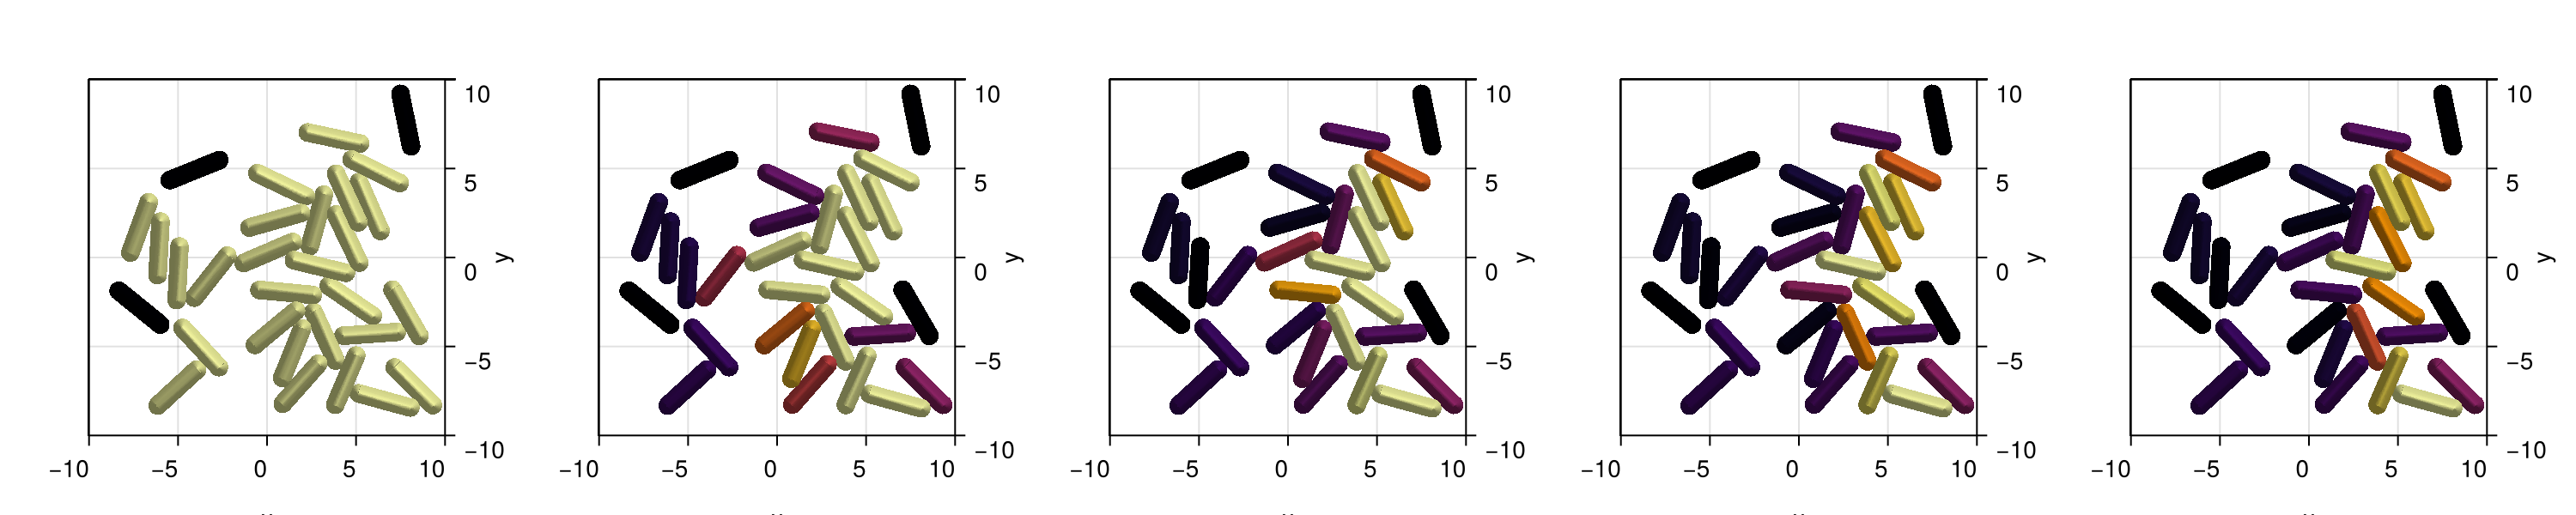

CairoMakie.Screen{IMAGE}


In [9]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:type],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

In [10]:
using JSON

function log_community_state(parameters::OrderedDict, t::Int, path::String = "parameters_2.txt")
    # Convert keys to strings so JSON can serialize them
    string_keys = Dict(string(k) => v for (k, v) in parameters)
    # Build entry
    entry = Dict("t" => t, "parameters" => string_keys)
    # Save as a JSON line
    open(path, "a") do io
        println(io, JSON.json(entry))
    end
end


function load_parameters_log(path::String = "parameters_2.txt")
    log = Dict{Int, OrderedDict{Symbol, Any}}()
    for line in eachline(path)
        entry = JSON.parse(line)
        t = entry["t"]
        raw_params = entry["parameters"]
        params = OrderedDict(Symbol(k) => v for (k, v) in raw_params)
        log[t] = params
    end
    times = sort(collect(keys(log)))
    com_array = [log[t] for t in times]
    return com_array, times
end



load_parameters_log (generic function with 2 methods)

In [11]:
steps=8000
saveEach=100
N=100
loadToPlatform!(com,preallocateAgents=N)
open("parameters_2.txt", "w") do f
    # clear file at start
end


for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if  N - com.N[1] < 2*com.N[1]
            N = 4*com.N[1]
        end
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end


Step 100 N: 30


Step 200 N: 30


Step 300 N: 30


Step 400 N: 30


Step 500 N: 30


Step 600 N: 30
Step 700 N: 30


Step 800 N: 30


Step 900 N: 30


Step 1000 N: 30
Step 1100 N: 30


Step 1200 N: 30
Step 1300 N: 30


Step 1400 N: 30


Step 1500 N: 30


Step 1600 N: 30
Step 1700 N: 30


Step 1800 N: 30


Step 1900 N: 30


Step 2000 N: 30


Step 2100 N: 30
Step 2200 N: 30


Step 2300 N: 30


Step 2400 N: 30


Step 2500 N: 30


Step 2600 N: 30
Step 2700 N: 30


Step 2800 N: 30


Step 2900 N: 30


Step 3000 N: 30
Step 3100 N: 30


Step 3200 N: 30


Step 3300 N: 30


Step 3400 N: 30


Step 3500 N: 30


Step 3600 N: 30
Step 3700 N: 30


Step 3800 N: 30


Step 3900 N: 30


Step 4000 N: 30


Step 4100 N: 30
Step 4200 N: 30


Step 4300 N: 30


Step 4400 N: 30


Step 4500 N: 30


Step 4600 N: 30


Step 4700 N: 30
Step 4800 N: 30


Step 4900 N: 30


Step 5000 N: 30


Step 5100 N: 30
Step 5200 N: 30


Step 5300 N: 30


Step 5400 N: 30


Step 5500 N: 30


Step 5600 N: 30
Step 5700 N: 30


Step 5800 N: 30


Step 5900 N: 30


Step 6000 N: 30


Step 6100 N: 30


Step 6200 N: 30
Step 6300 N: 30


Step 6400 N: 30


Step 6500 N: 30


Step 6600 N: 30
Step 6700 N: 30


Step 6800 N: 30


Step 6900 N: 30


Step 7000 N: 30


Step 7100 N: 30


Step 7200 N: 30
Step 7300 N: 30


Step 7400 N: 30


Step 7500 N: 30


Step 7600 N: 30


Step 7700 N: 30


Step 7800 N: 30
Step 7900 N: 30


Step 8000 N: 30


In [12]:
com_,times=load_parameters_log("parameters_2.txt")

(OrderedDict{Symbol, Any}[OrderedDict(:epsbb => Any[0.0038880000356584787], :W => Any[6.004923847058308e-8, 6.300372223932982e-9, 0.0, -3.3606106786265855e-9, 2.384804176358557e-8, 5.941808467468945e-8, -5.862840435355565e-9, -7.31883512128384e-11, 2.6147146670041366e-8, -4.5855115260451385e-9  …  5.483072129663924e-8, 1.1867499871698328e-8, -1.2954732397929547e-8, -3.3980036562297755e-8, -4.160092359484224e-8, -9.702113779042065e-9, -2.4505617535197644e-9, -5.78312375765222e-9, 2.6732371871673877e-9, 0.0], :fx => Any[-5.0270639206928536e-8, -8.195390677201431e-8, 0.0, 2.4378133289815196e-8, 2.7864835772106744e-8, 2.3819393391022459e-7, 1.4881115895093444e-8, -1.1872175775806681e-7, 2.3449355524007842e-7, -1.1651175668703218e-7  …  -6.121577911244458e-8, -3.1262409549981385e-8, 8.222178848882322e-8, 2.3829990425383585e-7, -2.3432603768469562e-7, -6.279560693656094e-8, -1.8145135172176197e-8, -1.4878852816480048e-8, -1.4885538135445131e-8, 0.0], :x => Any[4.753535270690918, -7.155013561

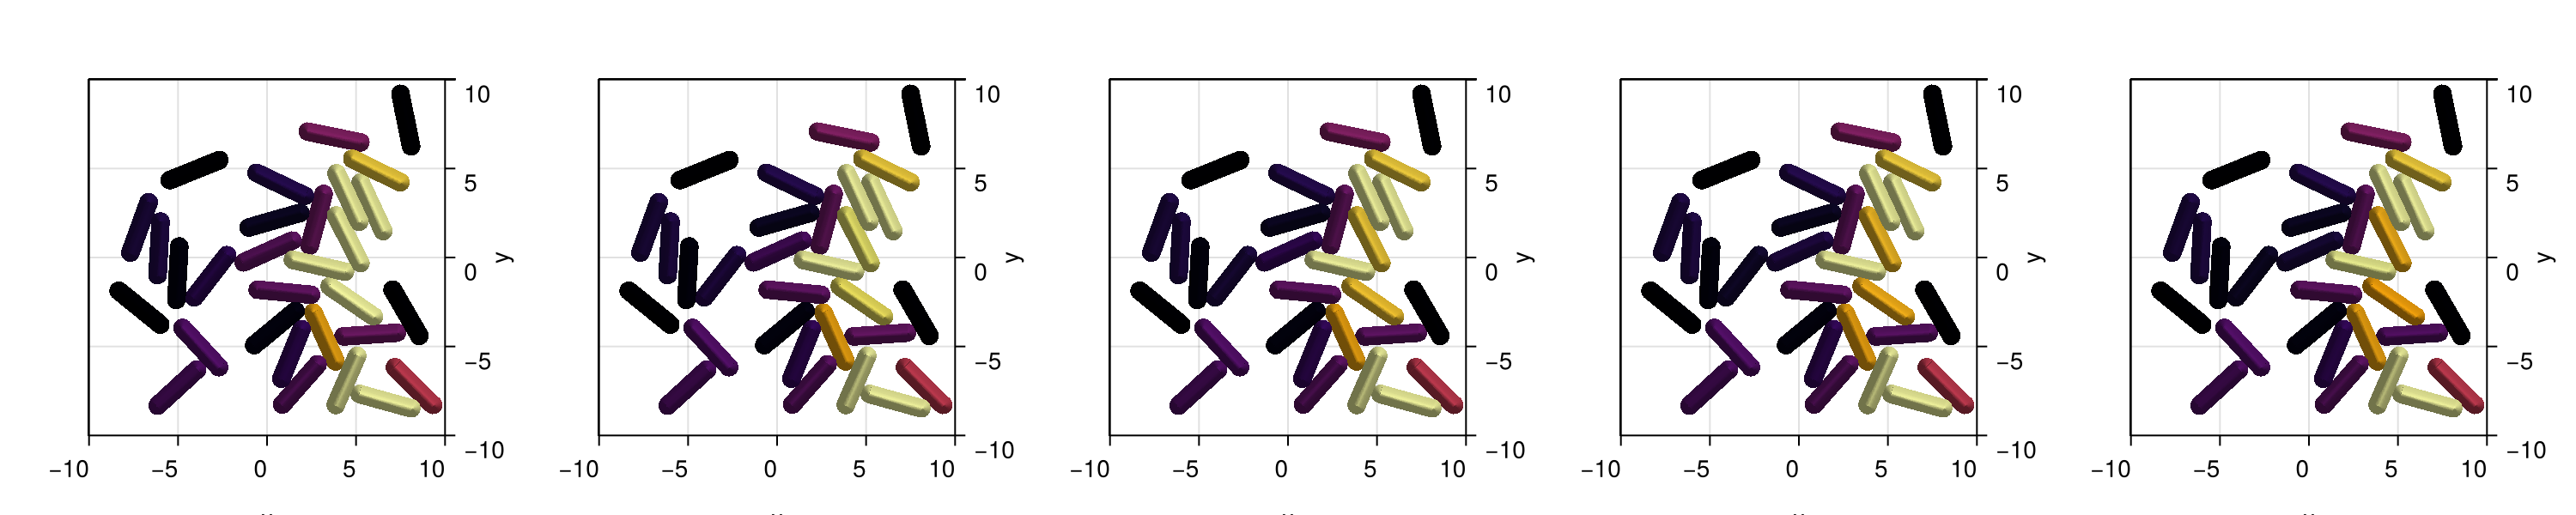

CairoMakie.Screen{IMAGE}


In [13]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com_)/4):length(com_);length(com_)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com_[j][:x],
    com_[j][:y],
    com_[j][:d],
    com_[j][:l],
    com_[j][:theta],
    com_[j][:type],
    com_[j][:pressure],
    colorrange = (0, maximum((p[:pressure][1]) for p in com_))
)

    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [14]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64,
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64,
                :σ=>Float64,
                :p_half=>Float64,
                :DMedium => Float64,
                :delta => Float64,
                :qrate => Float64, 
            ),
    
    medium = Dict(
        :mm => Float64        #Add a medium parameter
    ),

 
    agentODE = quote
        if type == 0
            dt(l) = l*growth/(1+α*pressure) #linear growth with growth dependent on the pressure over the cell
        end
        
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1)/10000 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    W=ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=0)
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    W=ww,
                    type=0)
            #Remove the old cell
            @removeAgent()
        end
        # Probability of releasing PGA with a saturating function
        pq = 1/(1+α*pressure)
        prelease = σ * mm^5 / (p_half^5 + mm^5)

        if CBMDistributions.uniform(0, 1) < prelease
            # PGA release!
            # You could mark it, count it, or log it here
            # @info "PGA released at step $(step) by agent ID $(id)"
            aux=CBMDistributions.rand_pm()
            @addAgent(
                    # x=((l+d)*(rand()-1/2)+aux*d/2)*cos(theta)+x,
                    # y=((l+d)*(rand()-1/2)-aux*d/2)*sin(theta)+y,
                    x=(CBMDistributions.uniform(-1,1)*(l+d)/2+aux*d/2)*cos(theta)+x,
                    y=(CBMDistributions.uniform(-1,1)*(l+d)/2-aux*d/2)*sin(theta)+y,
                    l=0,
                    d=0.5,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=1)

        end
        if CBMDistributions.uniform(0, 1) < pq
            mm += 1
        end

           

    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(mm) = DMedium*(@∂2(1,mm)+@∂2(2,mm)) - delta*mm # we only diffuse in x as the symmetry is in x
            # dt(mm) = DMedium*(@∂2(1,mm)+@∂2(2,mm))-delta*mm# we only diffuse in x as the symmetry is in x
       elseif @mediumBorder(1,-1) #x last
            mm = 0
        elseif @mediumBorder(1,1) #x fist??
            mm = 0 #Oscillatory behaviour
        elseif @mediumBorder(2,1) #y first
            mm = 0
        elseif @mediumBorder(2,-1) #y last
            mm = 0
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [15]:
com = Community(rods2dGrowth,
            N=1,
            dt=1.,
            simBox = [-100 100;-100 100.],
            NMedium=[100,100],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.n=30
com.Ebb=20. *m/(t^2*d)*1.E-3 #kPa
com.Ebg=10. *m/(t^2*d)*1.E-3 #kPa
com.Egg=5. *m/(t^2*d)*1.E-3 #kPa

# com.epsbb=5.E7 *m*d/t^2 #Pa um^2
# com.epsbg=18. *m*d/t^2 #Pa um^2
# com.epsgg=18. *m*d/t^2 #Pa um^2

com.etab=500 *m/(t*d) #Pa h
com.etag=500 *m/(t*d) #Pa h

com.DMedium = 1.E-3 /t #um^2/h
com.delta = 1.E-10
com.qrate = 1.E-12 
com.delta = 1.E-3 


com.growth = 0.5 * t
com.lMax = 3.     
com.σlTarget = .2 
com.α = 200
# com.σ = 0
com.σ = 2.E-4
com.type=0

com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  

com.p_half=100.

com.x = 0
com.y = 0
com.theta = 0;

In [16]:
steps=120000
saveEach=10000
N=100 

loadToPlatform!(com,preallocateAgents=N)
open("parameters_2.txt", "w") do f
    # clear file at start
end

for step in 1:steps
    
    step!(com)

    if step % saveEach == 0
        bringFromPlatform!(com)
        if N - com.N[1] <= 0
                println("Step ",step, " N: ", com.N[1], " preallocateAgents: ", N)
                @warn "More agents than preallocateAgents, stopping simulation."
                break
        elseif   N - com.N[1]  < 4*com.N[1]
                N = 15*com.N[1]
        end 
        println("Step ",step, " N: ", com.N[1])
        log_community_state(com.parameters, step)
        loadToPlatform!(com,preallocateAgents=N)
    end
end

Step 10000 N: 4


Step 20000 N: 8


Step 30000 N: 16


Step 40000 N: 32


Step 50000 N: 84


Step 60000 N: 166


Step 70000 N: 327


Step 80000 N: 577


Step 90000 N: 2258


Step 100000 N: 17434


Step 110000 N: 128411


Step 120000 N: 947483


In [17]:
com_load,times=load_parameters_log("parameters_2.txt")


(OrderedDict{Symbol, Any}[OrderedDict(:epsbb => Any[0.0], :DMedium => Any[3.6], :W => Any[-8.896004202907594e-10, -9.161078522715768e-11, -9.161078522715764e-11, -8.896004202907595e-10], :fx => Any[-8.795004724086981e-5, -8.748178070996086e-5, 8.748178070996086e-5, 8.795004724086981e-5], :x => Any[-3.1510866414524736, 0.8652980439469401, 3.1473898777632106, -0.8620029683457061], :σlTarget => Any[0.2], :delta => Any[0.001], :theta => Any[-2.0890346572315332e-5, -1.0990497866526561e-5, -1.0990497866526561e-5, -2.0890346572315332e-5], :qrate => Any[1.0e-12], :epsbg => Any[0.0]…), OrderedDict(:epsbb => Any[0.0], :DMedium => Any[3.6], :W => Any[0.0, -1.2202907922425993e-5, -1.1184932150911382e-5, 7.873802823906338e-6, 0.0, 8.3698741292997e-6, -1.2090334128638704e-5, -1.0495055273833449e-5], :fx => Any[0.0, 1.100208468004053e-5, 1.6107490651375374e-5, 6.088641252857482e-6, 0.0, -6.292894631211558e-6, -1.705572459002207e-5, -9.366442150518524e-6], :x => Any[-4.344063568972559, -0.191121505837

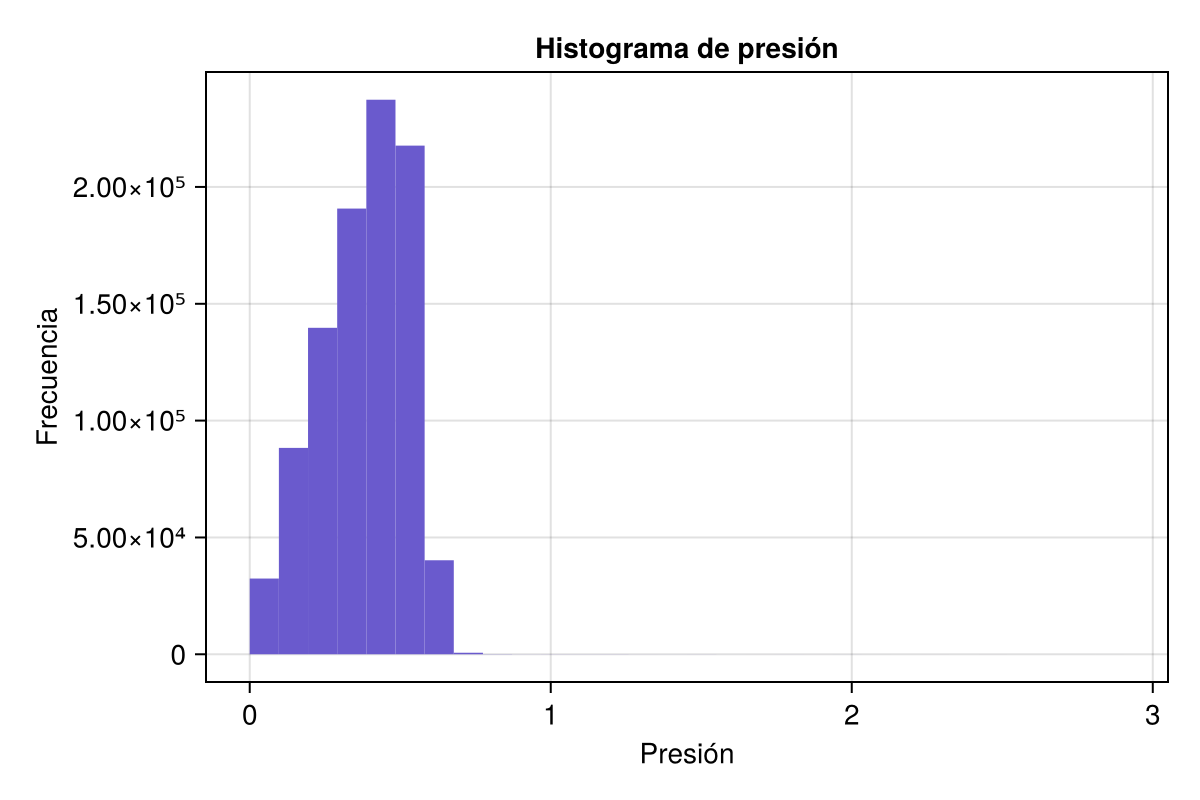

In [18]:
# Elegimos un frame, por ejemplo el último
p = com_load[end][:pressure]

# Creamos la figura y el eje
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

In [19]:
 maximum(maximum(p -> maximum(p[:mm]), com_load))

2096.044723113383

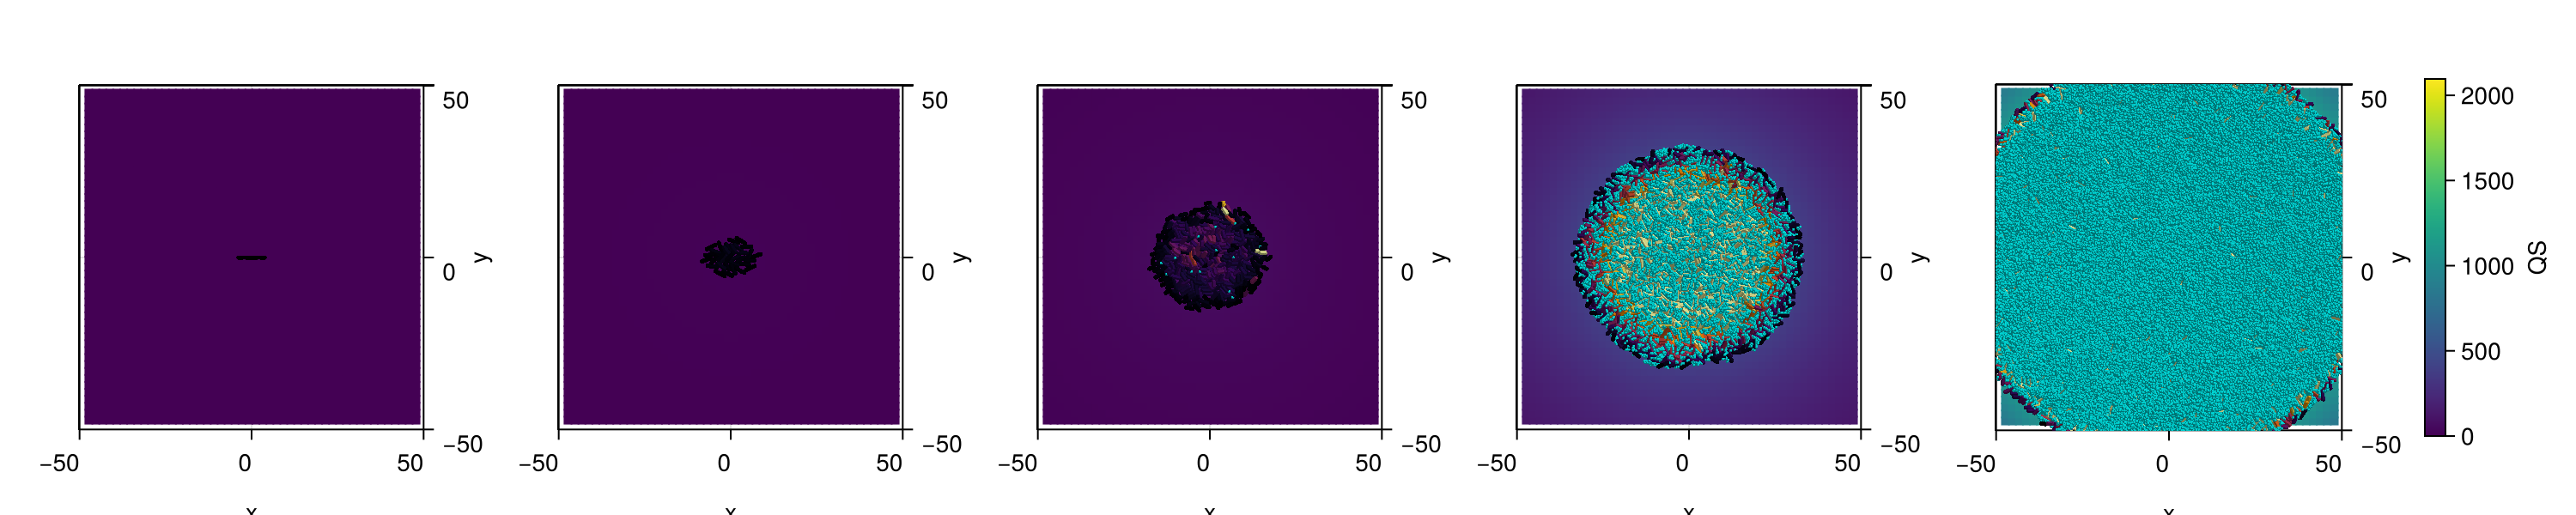

CairoMakie.Screen{IMAGE}


In [20]:
# Colormap común y colorrange fijo
colormap = :viridis
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:mm]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                Float64.(hcat(com_load[j][:mm]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    plotMixedAgents2D!(
    ax,
    com_load[j][:x],
    com_load[j][:y],
    com_load[j][:d],
    com_load[j][:l],
    com_load[j][:theta],
    com_load[j][:type],
    com_load[j][:pressure],
    colorrange = (0, 0.03)
    )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

In [21]:
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:mm]), com_load)))


(0.0, 2096.044723113383)

In [22]:
com_load[end][:mm] #Last medium state

100-element Vector{Any}:
 Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 Any[0.0, 1.0508205834193896, 2.102248944429726, 3.1548831706175715, 4.209301951607068, 5.266054836358767, 6.325652441277701, 7.388556598231013, 8.455170436370693, 9.525828397754987  …  9.499451183577957, 8.432352585207449, 7.369077229660105, 6.309317511761368, 5.2526976093956, 4.198783283212706, 3.147091667064186, 2.0971010375780286, 1.0482605583522124, 0.0]
 Any[0.0, 2.102302358750234, 4.205830618001078, 6.311791306810205, 8.421352174264612, 10.535622709094936, 12.655634557309806, 14.782321814774908, 16.91650118118847, 19.05885197402314  …  19.006332003594963, 16.87107402883911, 14.74354534749309, 12.623120567270997, 10.509037768688477, 8.400418136009927, 6.296285561423296, 4.195586200488296, 2.0972079711276974, 0.0]
 Any[0.0, 3.155096919527796, 6.312058555677262, 9.472720590575477, 12.63886057880579, 15.812168740675334, 18.994218593564344, 22.186437383

In [23]:
com_load[1][:delta],
com_load[1][:qrate]

(Any[0.001], Any[1.0e-12])

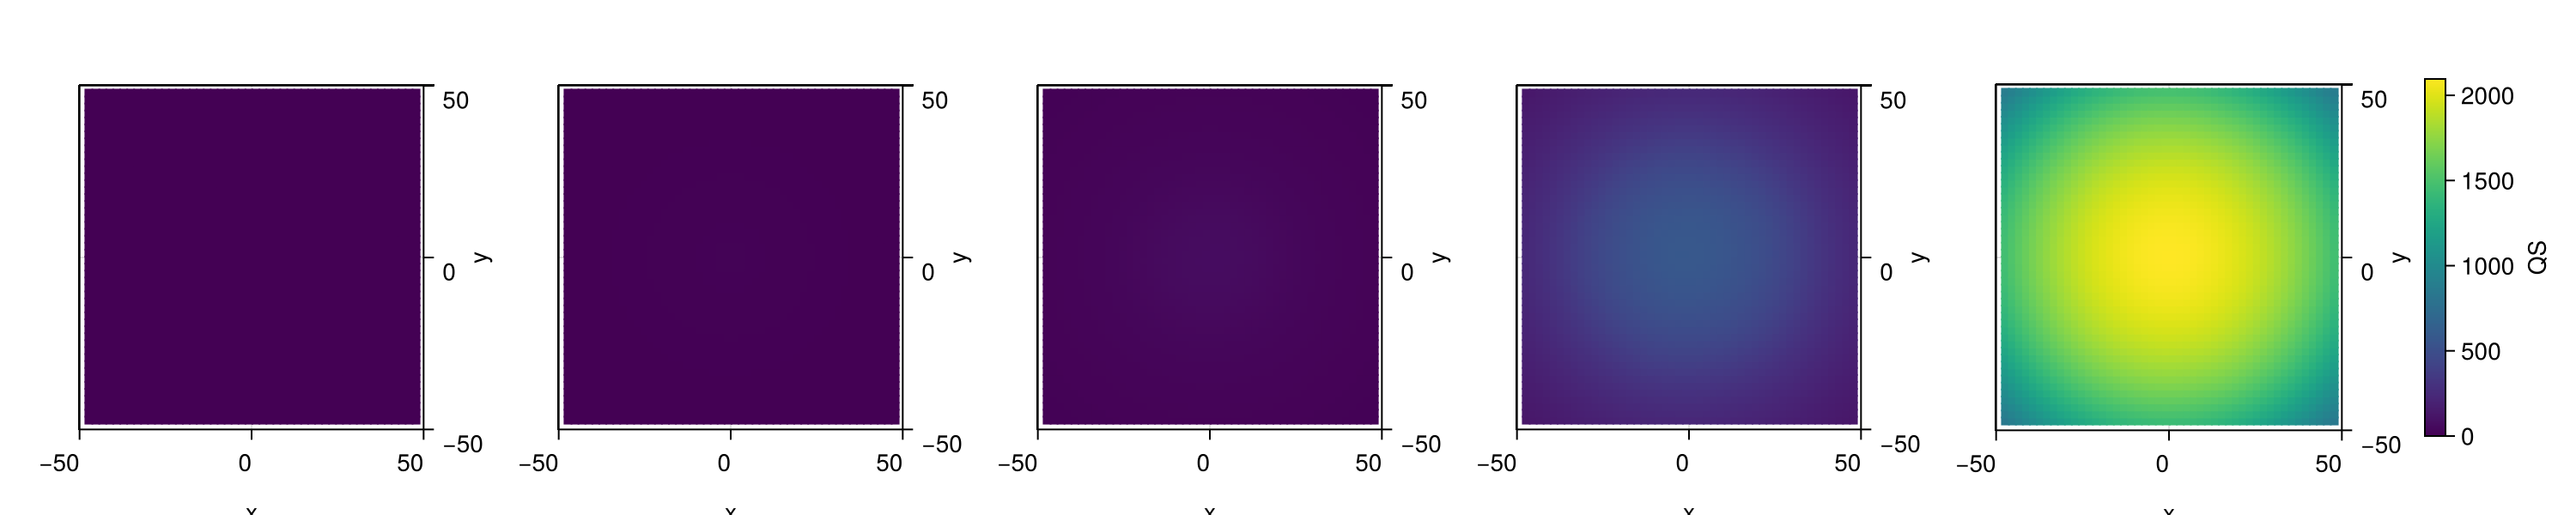

CairoMakie.Screen{IMAGE}


In [24]:
# Colormap común y colorrange fijo
colormap = :viridis
colorrange = (0.0,  maximum(maximum(p -> maximum(p[:mm]), com_load)))



fig = Figure(size=(1500,300))

js = [1:round(Int, length(com_load)/4):length(com_load); length(com_load)]

for (i,j) in enumerate(js)
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )
    m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                Float64.(hcat(com_load[j][:mm]...)),
                colormap = colormap,
                colorrange = colorrange
            )
    

    # plotMixedAgents2D!(
    # ax,
    # com_load[j][:x],
    # com_load[j][:y],
    # com_load[j][:d],
    # com_load[j][:l],
    # com_load[j][:theta],
    # com_load[j][:type],
    # com_load[j][:pressure],
    # colorrange = (0, 0.03)
    # )

    xlims!(-50,50)
    ylims!(-50,50)
end

# Añadir colorbar común al final
Colorbar(fig[1, length(js) + 1],
    colormap = colormap,
    colorrange = colorrange,
    label = "QS"
)

display(fig)

In [25]:

# # Configuración general
# colormap = :viridis
# colorrange = (0.0, maximum(com.mm))

# # Crear figura y ejes
# fig = Figure(size = (800, 600))
# grid = fig[1, 1] = GridLayout()
# ax = Axis(grid[1, 1]; aspect = DataAspect())
# Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



# Makie.record(fig, "bacterias_video_pressure_qs_proves.mp4", 1:length(com_load); framerate = 15) do j
 
#     Makie.empty!(ax)
#     # Preparar heatmap observable para actualizar luego
#     x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.mm)[1])
#     y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.mm)[2])
#     z = copy(hcat(com_load[j][:mm]...))  # inicializa con primer frame

#     hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

#     plotMixedAgents2D!(
#         ax,
#         com_load[j][:x],
#         com_load[j][:y],
#         com_load[j][:d],
#         com_load[j][:l],
#         com_load[j][:theta],
#         com_load[j][:type],
#         com_load[j][:pressure],
#         colorrange = (0, 0.03)
#     )


#     xlims!(ax, -50, 50)
#     ylims!(ax, -50, 50)
# end


In [26]:


# # Configuración general
# colormap = :viridis
# colorrange = (0.0, maximum(com.mm))

# # Crear figura y ejes
# fig = Figure(size = (800, 600))
# grid = fig[1, 1] = GridLayout()
# ax = Axis(grid[1, 1]; aspect = DataAspect())
# Colorbar(grid[1, 2], colormap=colormap, colorrange=colorrange, label="QS")  # una vez



# Makie.record(fig, "bacterias_video_pressure_qs_2_proves.mp4", 1:length(com_load); framerate = 15) do j
 
#     Makie.empty!(ax)
#     # Preparar heatmap observable para actualizar luego
#     x = range(com.simBox[1,1], com.simBox[1,2], length=size(com.mm)[1])
#     y = range(com.simBox[2,1], com.simBox[2,2], length=size(com.mm)[2])
#     z = copy(hcat(com_load[j][:mm]...))  # inicializa con primer frame

#     hm = heatmap!(ax, x, y, z; colormap=colormap, colorrange=colorrange)

#     # plotMixedAgents2D!(
#     #     ax,
#     #     com_load[j][:x],
#     #     com_load[j][:y],
#     #     com_load[j][:d],
#     #     com_load[j][:l],
#     #     com_load[j][:theta],
#     #     com_load[j][:type],
#     #     com_load[j][:pressure],
#     #     colorrange = (0, 0.03)
#     # )


#     xlims!(ax, -50, 50)
#     ylims!(ax, -50, 50)
# end
